# Part 1: Module 1: LLM Foundations: Hands-On Lab Notebook

## Learning Objectives
By the end of this lab, you will be able to:
- Understand and experiment with the concepts of context window, tokenization, embeddings, logits, temperature, and response formats in Large Language Models (LLMs).
- Use AWS Bedrock to interact with foundational models (preferably Claude Sonnet, or other Claude/Nova/Titan models).
- Visualize and manipulate LLM parameters to see their effects on outputs.
- Run the lab in both MyBinder and AWS SageMaker environments.


## Setup

This notebook is compatible with both [MyBinder](https://mybinder.org/) and AWS SageMaker.

**Environment Notes:**
- **MyBinder:** You must provide your own AWS credentials (see below).
- **AWS SageMaker:** Credentials are pre-configured in your environment.

**Install dependencies:**
```python
!pip install boto3 matplotlib scikit-learn
```

**AWS Credentials Setup:**
- **MyBinder:** Set your credentials as environment variables in a cell (do NOT share credentials):
```python
import os
os.environ['AWS_ACCESS_KEY_ID'] = 'YOUR_ACCESS_KEY'
os.environ['AWS_SECRET_ACCESS_KEY'] = 'YOUR_SECRET_KEY'
os.environ['AWS_DEFAULT_REGION'] = 'us-west-2'  # or your region
```
- **SageMaker:** No action needed unless you want to override the default region.

**Licensing Notes:**
- [boto3](https://github.com/boto/boto3) (Apache 2.0)
- [matplotlib](https://matplotlib.org/stable/users/project/license.html) (PSF)
- [scikit-learn](https://scikit-learn.org/stable/about.html#license) (BSD)
- Any custom code in this notebook is MIT licensed.


In [14]:
# MyBinder users: set your credentials here (do NOT share real keys)
#import os
# os.environ['AWS_ACCESS_KEY_ID'] = 'YOUR_ACCESS_KEY'
# os.environ['AWS_SECRET_ACCESS_KEY'] = 'YOUR_SECRET_KEY'
# os.environ['AWS_DEFAULT_REGION'] = 'us-west-2'  # or your region

# Set the Claude model ID (update as needed for your account)
model_id = 'anthropic.claude-3-5-sonnet-20241022-v2:0'  # Example: Claude 3.5 Sonnet

# You can find available model IDs using the earlier Bedrock listing cell.


## 1. Context Window Exploration

**What is a context window?**
The context window is the maximum number of tokens (input + output) a model can consider at once. If your prompt is too long, there will be less room for the model's response. If you exceed the limit, the model will stop or truncate its output.

**Activity Instructions:**
- Try different prompt lengths and response lengths.
- Observe what happens as you approach or exceed the model's context window.
- Note: Most modern LLMs have context windows between 8,000 and 200,000 tokens.

**Expected Output:**
- The model's response, or an error/truncation if the context window is exceeded.


In [6]:
# Connect to AWS Bedrock and list available Claude models
import os
import boto3
from botocore.exceptions import NoCredentialsError, ClientError

region = os.environ.get('AWS_DEFAULT_REGION', 'us-east-1')
bedrock = boto3.client('bedrock-runtime', region_name=region)

In [15]:
# Experiment: Try different prompt and max_tokens
prompt = "Write a poem about the universe"

# Create the request body
request_body = {
    "anthropic_version": "bedrock-2023-05-31",
    "max_tokens": 100,
    "messages": [
        {
            "role": "user",
            "content": prompt
        }
    ],
    "temperature": 0.7,
    "top_p": 0.9
}

import json
response = bedrock.invoke_model(
    modelId=model_id,
    body=json.dumps(request_body),
    contentType='application/json'
)
result = json.loads(response['body'].read())
print('Model response:')
print(result.get('completion', result))

Model response:
{'id': 'msg_bdrk_01MtRaK8um8NywGc2owcgLNu', 'type': 'message', 'role': 'assistant', 'model': 'claude-3-5-sonnet-20241022', 'content': [{'type': 'text', 'text': 'Here\'s a poem about the universe:\n\n"Cosmic Dance"\n\nIn endless dark and sparkling light,\nBillions of stars burn fierce and bright,\nGalaxies spiral, dance and sway,\nAs cosmic winds sweep time away.\n\nFrom ancient dust we all were born,\nWhen first light broke that distant morn,\nThrough countless years of space and time,\nA universe of grand design.\n\nBlack holes devour with hungry might,\nWhile nebul'}], 'stop_reason': 'max_tokens', 'stop_sequence': None, 'usage': {'input_tokens': 13, 'output_tokens': 100}}


## 2. Tokenization

**What is tokenization?**
Tokenization is the process of splitting text into small pieces called tokens, which the model can process. Different models may tokenize the same text differently.

**Activity Instructions:**
- Enter different sentences and see how they are tokenized.
- Compare token counts for simple vs. complex/technical text.
- Try sentences with common words, rare words, numbers, and punctuation.

**Expected Output:**
- The list of tokens and the total token count for your input.


In [8]:
# Tokenization demo: Try different sentences
text = "Tokenize this input text and count the number of token. Next is a random string mskao1@r045tl"

import tiktoken
enc = tiktoken.get_encoding('cl100k_base')  # OpenAI's encoding, works for most LLMs

def tokenize(text):
        return enc.encode(text)

def detokenize(token_id):
    # Convert the token ID to bytes, then decode to string if possible
    token_bytes = enc.decode_single_token_bytes(token_id)
    try:
        token_str = token_bytes.decode('utf-8')
    except UnicodeDecodeError:
        token_str = repr(token_bytes)  # Use repr for non-utf8 bytes
    return token_str

# Get tokens
tokens = tokenize(text)

# Print token count
print(f"Total tokens: {len(tokens)}\n")
print(f"Total words: {len(text.split())}\n")

# Print each token ID and corresponding string
print("Token ID | Token String")
print("-" * 30)
for i, token_id in enumerate(tokens):
    token_str = detokenize(token_id)
    print(f"{token_id:8} | {repr(token_str)}")



Total tokens: 25

Total words: 16

Token ID | Token String
------------------------------
    3404 | 'Token'
     553 | 'ize'
     420 | ' this'
    1988 | ' input'
    1495 | ' text'
     323 | ' and'
    1797 | ' count'
     279 | ' the'
    1396 | ' number'
     315 | ' of'
    4037 | ' token'
      13 | '.'
    9479 | ' Next'
     374 | ' is'
     264 | ' a'
    4288 | ' random'
     925 | ' string'
     296 | ' m'
    4991 | 'sk'
    3524 | 'ao'
      16 | '1'
      31 | '@'
      81 | 'r'
   23785 | '045'
   11805 | 'tl'


## 3. Embeddings Visualization

**What are embeddings?**
Embeddings are numerical vector representations of text that capture meaning and relationships. Similar sentences have similar embeddings.

**Activity Instructions:**
- See how different sentences are represented as vectors.
- Visualize these vectors in 2D space.
- Sentences with similar meaning should cluster together.

**Note:** If AWS Bedrock's embedding API is not available, this activity will use dummy data.

**Expected Output:**
- A 2D scatter plot showing the relative positions of sentence embeddings.


Fetching embeddings from Amazon Bedrock Titan model...
Successfully retrieved 9 embeddings from Bedrock.
Embedding dimension: 1024


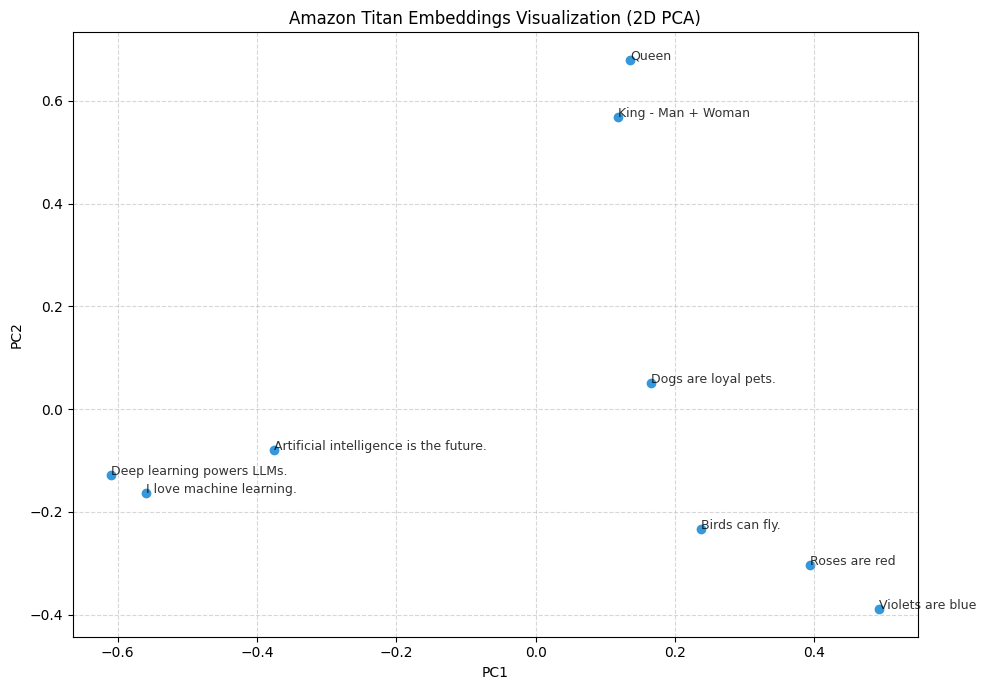


Similarity Matrix (Cosine Similarity):
'I love machine learning.' ↔ 'Artificial intelligence is the future.': 0.2567
'I love machine learning.' ↔ 'Dogs are loyal pets.': 0.0853
'I love machine learning.' ↔ 'Deep learning powers LLMs.': 0.4285
'I love machine learning.' ↔ 'Birds can fly.': 0.1026
'I love machine learning.' ↔ 'Roses are red': 0.0905
'I love machine learning.' ↔ 'Violets are blue': 0.0354
'I love machine learning.' ↔ 'King - Man + Woman': 0.1019
'I love machine learning.' ↔ 'Queen': 0.0730
'Artificial intelligence is the future.' ↔ 'Dogs are loyal pets.': 0.0424
'Artificial intelligence is the future.' ↔ 'Deep learning powers LLMs.': 0.2477
'Artificial intelligence is the future.' ↔ 'Birds can fly.': 0.1093
'Artificial intelligence is the future.' ↔ 'Roses are red': 0.0784
'Artificial intelligence is the future.' ↔ 'Violets are blue': 0.0483
'Artificial intelligence is the future.' ↔ 'King - Man + Woman': 0.1149
'Artificial intelligence is the future.' ↔ 'Queen': 0.0841


In [10]:
# Embeddings visualization using Amazon Bedrock Titan embedding model
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

sentences = [
    'I love machine learning.',
    'Artificial intelligence is the future.',
    'Dogs are loyal pets.',
    'Deep learning powers LLMs.',
    'Birds can fly.',
    'Roses are red',
    'Violets are blue',
    'King - Man + Woman',
    'Queen'
]

# Function to get embeddings from Bedrock Titan model
def get_bedrock_embeddings(sentences):  
    embeddings_list = []
    
    # Process each sentence
    for sentence in sentences:
        # Create request body for the Titan Embeddings model
        request_body = {
            "inputText": sentence
        }
        
        # Convert request body to JSON
        request_body_json = json.dumps(request_body)
        
        # Call the Bedrock API
        response = bedrock.invoke_model(
            modelId='amazon.titan-embed-text-v2:0',  # Titan text embedding model
            body=request_body_json
        )
        
        # Parse the response
        response_body = json.loads(response['body'].read())
        
        # Extract the embedding vector
        embedding = response_body['embedding']
        embeddings_list.append(embedding)
    
    # Convert list of embeddings to numpy array
    return np.array(embeddings_list)

# Get embeddings from Amazon Bedrock
print('Fetching embeddings from Amazon Bedrock Titan model...')
embeddings = get_bedrock_embeddings(sentences)
print(f'Successfully retrieved {len(embeddings)} embeddings from Bedrock.')
print(f'Embedding dimension: {embeddings.shape[1]}')

# Reduce from 1536D to 2D for visualization purposes
# PCA finds the principal components (directions of maximum variance) to preserve
# semantic relationships between sentences while enabling 2D plottingpca = PCA(n_components=2)
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Create visualization
plt.figure(figsize=(10, 7))
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], color='#3498db')
for i, txt in enumerate(sentences):
    plt.annotate(txt, (embeddings_2d[i,0], embeddings_2d[i,1]), fontsize=9, alpha=0.8)
plt.title('Amazon Titan Embeddings Visualization (2D PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Calculate and print similarity matrix (cosine similarity)
sim_matrix = cosine_similarity(embeddings)

print("\nSimilarity Matrix (Cosine Similarity):")
for i, s1 in enumerate(sentences):
    for j, s2 in enumerate(sentences):
        if i < j:  # Only print upper triangle to avoid redundancy
            print(f"'{s1}' ↔ '{s2}': {sim_matrix[i][j]:.4f}")

## 4. Logits, Temperature, and Sampling

**What are logits?**
Logits are raw scores assigned by the model to each possible next token. These are converted to probabilities using the softmax function.

**Temperature, top_p, and top_k:**
- **Temperature** controls randomness: low values make the model more deterministic, high values increase creativity.
- **top_p (nucleus sampling)** and **top_k** further control which tokens can be selected.

**Activity Instructions:**
- Experiment with different temperature values and see how the probability distribution changes.
- Observe which tokens become more or less likely as you adjust temperature.

**Expected Output:**
- A bar chart showing token probabilities for a given set of logits and temperature.


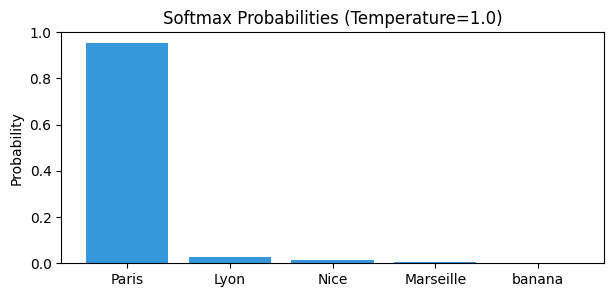

In [11]:
# Logits, temperature, and softmax demo
import numpy as np
import matplotlib.pyplot as plt

def softmax(logits, temperature=1.0):
    scaled = np.array(logits) / temperature
    exps = np.exp(scaled - np.max(scaled))
    return exps / np.sum(exps)

logits = [8.2, 4.6, 3.9, 3.2, -5.0]
tokens = ['Paris', 'Lyon', 'Nice', 'Marseille', 'banana']

def plot_probs(temperature):
    probs = softmax(logits, temperature)
    plt.figure(figsize=(7,3))
    plt.bar(tokens, probs, color='#3498db')
    plt.title(f'Softmax Probabilities (Temperature={temperature})')
    plt.ylabel('Probability')
    plt.ylim(0,1)
    plt.show()

# Try different temperatures
plot_probs(1.0)  # Default
# Students: Try plot_probs(0.5) or plot_probs(1.5) to see the effect


## 5. Experiment: Claude with Temperature, top_p, and top_k

In this lab, you'll experiment with the Claude model using different values for temperature, top_p, and top_k.

- **Temperature**: Controls randomness. Lower values (e.g., 0.2) make responses more deterministic; higher values (e.g., 1.0) increase creativity.
- **top_p (nucleus sampling)**: Limits the model to the smallest set of tokens whose cumulative probability is at least top_p.
- **top_k**: Limits the model to the top k most likely tokens.

**Instructions:**
- Enter a prompt and try different combinations of temperature, top_p, and top_k.
- Run the cell multiple times and compare the diversity and style of the responses.
- Observe how the output changes as you adjust each parameter.

**Expected Output:**
- The model's response for each set of parameters.


In [12]:
# Experiment with Claude Sonnet 3.7: temperature, top_p, top_kpython# Experiment with Claude Sonnet 3.7: Demonstrating deterministic vs. controlled randomness behavior
import json
import time

# Test prompt that will show the effects of different sampling parameters
prompt = """
List 3 random animal names.
"""

# Define different parameter configurations to test
# Note: According to Anthropic docs, temperature and top_p should not be used together
# We'll test various configurations to show the spectrum from deterministic to random
configurations = [
    # Deterministic configurations
    {"temperature": 0.0, "top_p": None, "top_k": None, "description": "Deterministic (temperature=0)"},
    {"temperature": 0.0, "top_p": None, "top_k": 1, "description": "Deterministic (top_k=1)"},
        
    # High randomness configurations
    {"temperature": 1.0, "top_p": None, "top_k": None, "description": "High temperature (1.0)"},
    {"temperature": None, "top_p": 1.0, "top_k": None, "description": "Maximum top_p (1.0)"}
]

# Number of times to run each configuration to demonstrate randomness effects
runs_per_config = 3

# Store results
results = []

print(f"Testing {len(configurations)} different sampling configurations with Claude Sonnet")
print(f"Each configuration will be run {runs_per_config} times to demonstrate randomness effects\n")

for config in configurations:
    print(f"\nTesting: {config['description']}")
    
    for run in range(runs_per_config):
        # Build request body with only the parameters that are not None
        body = {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": 100,
            "messages": [
                {
                    "role": "user",
                    "content": prompt
                }
            ]
        }
        
        # Add sampling parameters that are provided
        if config["temperature"] is not None:
            body["temperature"] = config["temperature"]
        if config["top_p"] is not None:
            body["top_p"] = config["top_p"]
        if config["top_k"] is not None:
            body["top_k"] = config["top_k"]
        
        try:
            # Call the model
            response = bedrock.invoke_model(
                modelId=model_id,
                body=json.dumps(body),
                contentType='application/json',
                accept='application/json'
            )
            
            # Parse the response
            result = json.loads(response['body'].read())
            completion = result['content'][0]['text'].strip()
            
            # Store the result
            results.append({
                "config": config["description"],
                "run": run + 1,
                "completion": completion,
                "parameters": ", ".join([f"{k}={v}" for k, v in 
                                        {k: v for k, v in config.items() 
                                         if k != 'description' and v is not None}.items()])
            })
            
            print(f"  Run {run + 1}: {completion}")
            
            # 1-second delay between API calls
            time.sleep(20.0)
            
        except Exception as e:
            # Check if it's a throttling-related exception
            if 'ThrottlingException' in str(e) :
                time.sleep(10.0)
            print(f"Error in run {run + 1} with config {config['description']}: {e}")
            results.append({
                "config": config["description"],
                "run": run + 1,
                "completion": f"ERROR: {str(e)}",
                "parameters": ", ".join([f"{k}={v}" for k, v in 
                                        {k: v for k, v in config.items() 
                                         if k != 'description' and v is not None}.items()])
            })

# Analyze results to demonstrate deterministic vs. random behavior
deterministic_configs = []
random_configs = []

for config in configurations:
    # Get all responses for this configuration
    config_results = [r["completion"] for r in results if r["config"] == config["description"]]
    
    # If all responses are identical, the configuration is deterministic
    is_deterministic = all(r == config_results[0] for r in config_results)
    
    if is_deterministic:
        deterministic_configs.append(config["description"])
    else:
        random_configs.append(config["description"])

Testing 4 different sampling configurations with Claude Sonnet
Each configuration will be run 3 times to demonstrate randomness effects


Testing: Deterministic (temperature=0)
  Run 1: Here are 3 random animal names:

1. Platypus
2. Giraffe
3. Penguin
  Run 2: Here are 3 random animal names:

1. Platypus
2. Giraffe
3. Penguin
  Run 3: Here are 3 random animal names:

1. Platypus
2. Giraffe
3. Penguin

Testing: Deterministic (top_k=1)
  Run 1: Here are 3 random animal names:

1. Platypus
2. Giraffe
3. Penguin
  Run 2: Here are 3 random animal names:

1. Platypus
2. Giraffe
3. Penguin
  Run 3: Here are 3 random animal names:

1. Platypus
2. Giraffe
3. Penguin

Testing: High temperature (1.0)
  Run 1: Here are 3 random animal names:

1. Platypus
2. Okapi
3. Pangolin
  Run 2: Here are 3 random animal names:

1. Platypus
2. Giraffe
3. Octopus
  Run 3: Here are 3 random animal names:

1. Platypus
2. Pangolin
3. Capybara

Testing: Maximum top_p (1.0)
  Run 1: Here are 3 random animal names:


## 6. Response Format: Free-form vs. Structured Output

LLMs can return responses as free-form text or in a structured format (like JSON).

- **Free-form text** is natural and easy for humans to read, but harder for programs to process.
- **Structured output** (e.g., JSON) is predictable and easy for other software to use.

**Instructions:**
- Enter a prompt and try it first as a free-form request, then as a request for structured (JSON) output.
- Compare the results.
- Example: Ask for a weather report as both a natural sentence and as a JSON object.

**Expected Output:**
- The model's response in both formats.


In [13]:
# Response format: Free-form vs. structured (JSON)
prompt = "Describe a basic cup of coffee in detail, including its appearance, temperature, smell, and taste."
request_body = {
    "anthropic_version": "bedrock-2023-05-31",
    "max_tokens": 100,
    "messages": [
        {
            "role": "user",
            "content": prompt
        }
    ]
}

import json
response = bedrock.invoke_model(
    modelId=inference_profile,
    body=json.dumps(request_body),
    contentType='application/json'
)

result = json.loads(response['body'].read())
# Extract text from content field
free_form_response = result['content'][0]['text'] if 'content' in result and result['content'] else "No response text found"
print('Free-form response:')
print(free_form_response)
print("\n" + "-"*50 + "\n")

# Response format: structured (JSON)
prompt += "Please format your response as a JSON object."
request_body = {
    "anthropic_version": "bedrock-2023-05-31",
    "max_tokens": 100,
    "messages": [
        {
            "role": "user",
            "content": prompt
        }
    ]
}
response = bedrock.invoke_model(
    modelId=inference_profile,
    body=json.dumps(request_body),
    contentType='application/json'
)

result = json.loads(response['body'].read())
# Extract JSON from content field
json_text = result['content'][0]['text'] if 'content' in result and result['content'] else "{}"

# Try to parse the text as JSON and pretty print it
try:
    json_object = json.loads(json_text)
    print('JSON response (pretty-printed):')
    print(json.dumps(json_object, indent=2))
except json.JSONDecodeError:
    print('Raw response (not valid JSON):')
    print(json_text)

Free-form response:
A basic cup of coffee presents itself as a deep brown liquid, nearly black at its center while showing subtle mahogany highlights where light catches its surface. Small wisps of steam rise from the hot surface, dancing and disappearing into the air. The coffee fills the ceramic mug close to the rim, its surface tension creating a slight dome.

The temperature is notably hot - around 160°F - warm enough that you feel the heat radiating through the mug into your hands.

--------------------------------------------------

Raw response (not valid JSON):
{
  "beverage": "Coffee",
  "appearance": {
    "color": "Deep brown to black",
    "surface": "Slightly glossy",
    "opacity": "Opaque",
    "crema": "Thin layer of light brown foam on top"
  },
  "temperature": {
    "serving": "Hot",
    "approximate_fahrenheit": 165,
    "approximate_celsius":
